# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import os
import cv2

### Change directory

In [6]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Lab'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the training data from train.csv file

In [5]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Lab')

### Print the shape of the train dataset

In [7]:
df=pd.read_csv('train_labels.csv')
df.shape

(173, 8)

In [8]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [9]:
IMAGE_SIZE=128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [13]:
!pip install rarfile

In [14]:
import rarfile
images_zip_path = 'images_racoon.rar'
with rarfile.RarFile(images_zip_path) as rf:
    rf.extractall()

In [15]:
import csv
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height

In [17]:
paths

['raccoon-17.jpg',
 'raccoon-11.jpg',
 'raccoon-63.jpg',
 'raccoon-63.jpg',
 'raccoon-60.jpg',
 'raccoon-69.jpg',
 'raccoon-180.jpg',
 'raccoon-200.jpg',
 'raccoon-141.jpg',
 'raccoon-19.jpg',
 'raccoon-84.jpg',
 'raccoon-124.jpg',
 'raccoon-182.jpg',
 'raccoon-111.jpg',
 'raccoon-91.jpg',
 'raccoon-79.jpg',
 'raccoon-93.jpg',
 'raccoon-20.jpg',
 'raccoon-42.jpg',
 'raccoon-139.jpg',
 'raccoon-58.jpg',
 'raccoon-71.jpg',
 'raccoon-183.jpg',
 'raccoon-1.jpg',
 'raccoon-169.jpg',
 'raccoon-82.jpg',
 'raccoon-4.jpg',
 'raccoon-101.jpg',
 'raccoon-10.jpg',
 'raccoon-166.jpg',
 'raccoon-184.jpg',
 'raccoon-38.jpg',
 'raccoon-120.jpg',
 'raccoon-142.jpg',
 'raccoon-149.jpg',
 'raccoon-51.jpg',
 'raccoon-43.jpg',
 'raccoon-123.jpg',
 'raccoon-66.jpg',
 'raccoon-9.jpg',
 'raccoon-178.jpg',
 'raccoon-47.jpg',
 'raccoon-167.jpg',
 'raccoon-54.jpg',
 'raccoon-77.jpg',
 'raccoon-155.jpg',
 'raccoon-89.jpg',
 'raccoon-153.jpg',
 'raccoon-179.jpg',
 'raccoon-115.jpg',
 'raccoon-64.jpg',
 'raccoon-56

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [68]:
batch_images = []
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for p in paths:
    folder_path='/images'
    image = cv2.imread(folder_path+p,cv2.IMREAD_COLOR)
    if image is None: continue
    image = cv2.resize(image,(128,128))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    batch_images[i] = preprocess_input(np.array(image, dtype=np.float32))


In [69]:
batch_images.shape

(173, 128, 128, 3)

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [57]:
pwd

'/content/drive/My Drive/Colab Notebooks/Lab'

In [70]:
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

In [71]:
model = MobileNet(input_shape=(128, 128, 3), include_top=False) 
for layer in model.layers:
    layer.trainable = False
model1 = model.layers[-1].output
model1 = Conv2D(4, kernel_size=4,name="coords")(model1)
model1 = Reshape((4,))(model1)

myModel = Model(inputs=model.input,outputs = model1)

In [72]:
myModel.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

### Define a custom loss function IoU which calculates Intersection Over Union

In [73]:
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [74]:
myModel.compile(loss="mse", optimizer="adam", metrics=[IoU])

In [58]:
import tensorflow as tf

In [66]:
tf.__version__

'2.3.0'

In [75]:
myModel.fit(batch_images, coords, epochs=30, batch_size = 32, verbose=1)

Epoch 1/30
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
6/6 [==============================] - 2s 300ms/step - loss: 6028.7627 - IoU: 0.0339
Epoch 2/30
6/6 [==============================] - 2s 296ms/step - loss: 5267.0562 - IoU: 0.0203
Epoch 3/30
6/6 [==============================] - 2s 303ms/step - loss: 4597.7666 - IoU: 0.0213
Epoch 4/30
6/6 [=======================

### Pick a test image from the given data

In [98]:
test_img= 'images/raccoon-35.jpg'
unscaled= cv2.imread(test_img)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [99]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [100]:
region = myModel.predict(x=np.array([feat_scaled]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

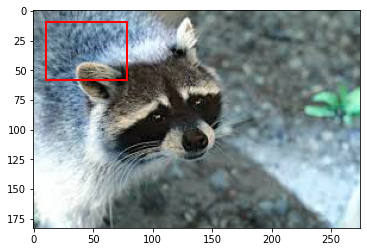

In [101]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()